In [1]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [2]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take time to download

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2019-10-20 20:13:51--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 103.2.49.240, 2001:3b8:208:19e::e59, 2001:3b8:208:1a7::e59, ...
Connecting to download.microsoft.com (download.microsoft.com)|103.2.49.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  42.2MB/s    in 17s     

2019-10-20 20:14:08 (46.0 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [4]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Expected Output:
# 12501
# 12501

12501
12501


In [5]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [6]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [7]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# Expected output:
# 11250
# 11250
# 1250
# 1250

11250
11250
1250
1250


In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])


In [9]:

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [10]:
# Note that this may take some time.
history = model.fit_generator(train_generator,
                              epochs=50,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/50
224/225 [============================>.] - ETA: 0s - loss: 0.6478 - acc: 0.6610

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 48s 212ms/step - loss: 0.6473 - acc: 0.6613 - val_loss: 0.5124 - val_acc: 0.7532
Epoch 2/50
224/225 [============================>.] - ETA: 0s - loss: 0.4903 - acc: 0.7648

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 199ms/step - loss: 0.4897 - acc: 0.7650 - val_loss: 0.4540 - val_acc: 0.7908
Epoch 3/50
224/225 [============================>.] - ETA: 0s - loss: 0.4262 - acc: 0.8031

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 201ms/step - loss: 0.4261 - acc: 0.8030 - val_loss: 0.4241 - val_acc: 0.8068
Epoch 4/50
224/225 [============================>.] - ETA: 0s - loss: 0.3695 - acc: 0.8339

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 201ms/step - loss: 0.3695 - acc: 0.8337 - val_loss: 0.4249 - val_acc: 0.8080
Epoch 5/50
224/225 [============================>.] - ETA: 0s - loss: 0.3138 - acc: 0.8627

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 201ms/step - loss: 0.3140 - acc: 0.8626 - val_loss: 0.4476 - val_acc: 0.8052
Epoch 6/50
224/225 [============================>.] - ETA: 0s - loss: 0.2527 - acc: 0.8917

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 200ms/step - loss: 0.2529 - acc: 0.8916 - val_loss: 0.4147 - val_acc: 0.8332
Epoch 7/50
224/225 [============================>.] - ETA: 0s - loss: 0.1899 - acc: 0.9227

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 200ms/step - loss: 0.1898 - acc: 0.9227 - val_loss: 0.4798 - val_acc: 0.8332
Epoch 8/50
224/225 [============================>.] - ETA: 0s - loss: 0.1341 - acc: 0.9489

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 200ms/step - loss: 0.1340 - acc: 0.9489 - val_loss: 0.4802 - val_acc: 0.8336
Epoch 9/50
224/225 [============================>.] - ETA: 0s - loss: 0.0908 - acc: 0.9684

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 46s 203ms/step - loss: 0.0906 - acc: 0.9685 - val_loss: 0.6366 - val_acc: 0.8308
Epoch 10/50
224/225 [============================>.] - ETA: 0s - loss: 0.0628 - acc: 0.9790

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 202ms/step - loss: 0.0628 - acc: 0.9790 - val_loss: 0.5845 - val_acc: 0.8312
Epoch 11/50
224/225 [============================>.] - ETA: 0s - loss: 0.0482 - acc: 0.9852

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 200ms/step - loss: 0.0480 - acc: 0.9852 - val_loss: 0.7408 - val_acc: 0.8316
Epoch 12/50
224/225 [============================>.] - ETA: 0s - loss: 0.0401 - acc: 0.9884

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 200ms/step - loss: 0.0400 - acc: 0.9884 - val_loss: 0.8658 - val_acc: 0.8324
Epoch 13/50
224/225 [============================>.] - ETA: 0s - loss: 0.0494 - acc: 0.9865

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 200ms/step - loss: 0.0493 - acc: 0.9866 - val_loss: 0.7621 - val_acc: 0.8220
Epoch 14/50
224/225 [============================>.] - ETA: 0s - loss: 0.0258 - acc: 0.9917

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 201ms/step - loss: 0.0257 - acc: 0.9917 - val_loss: 0.8504 - val_acc: 0.8284
Epoch 15/50
224/225 [============================>.] - ETA: 0s - loss: 0.0367 - acc: 0.9900

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 201ms/step - loss: 0.0365 - acc: 0.9900 - val_loss: 0.9312 - val_acc: 0.8336
Epoch 16/50
224/225 [============================>.] - ETA: 0s - loss: 0.0208 - acc: 0.9939

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 199ms/step - loss: 0.0211 - acc: 0.9939 - val_loss: 1.0120 - val_acc: 0.8312
Epoch 17/50
224/225 [============================>.] - ETA: 0s - loss: 0.0321 - acc: 0.9908

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 201ms/step - loss: 0.0319 - acc: 0.9908 - val_loss: 0.9202 - val_acc: 0.8344
Epoch 18/50
224/225 [============================>.] - ETA: 0s - loss: 0.0297 - acc: 0.9917

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 200ms/step - loss: 0.0296 - acc: 0.9917 - val_loss: 1.0659 - val_acc: 0.8308
Epoch 19/50
224/225 [============================>.] - ETA: 0s - loss: 0.0285 - acc: 0.9920

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 201ms/step - loss: 0.0284 - acc: 0.9920 - val_loss: 1.0138 - val_acc: 0.8320
Epoch 20/50
224/225 [============================>.] - ETA: 0s - loss: 0.0298 - acc: 0.9919

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 200ms/step - loss: 0.0297 - acc: 0.9920 - val_loss: 0.9674 - val_acc: 0.8320
Epoch 21/50
224/225 [============================>.] - ETA: 0s - loss: 0.0243 - acc: 0.9932

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 200ms/step - loss: 0.0242 - acc: 0.9932 - val_loss: 1.1500 - val_acc: 0.8304
Epoch 22/50
224/225 [============================>.] - ETA: 0s - loss: 0.0284 - acc: 0.9925

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 201ms/step - loss: 0.0283 - acc: 0.9925 - val_loss: 1.0712 - val_acc: 0.8296
Epoch 23/50
224/225 [============================>.] - ETA: 0s - loss: 0.0432 - acc: 0.9911

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 200ms/step - loss: 0.0437 - acc: 0.9911 - val_loss: 1.1940 - val_acc: 0.8192
Epoch 24/50
224/225 [============================>.] - ETA: 0s - loss: 0.0353 - acc: 0.9914

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 200ms/step - loss: 0.0351 - acc: 0.9914 - val_loss: 1.0420 - val_acc: 0.8228
Epoch 25/50
224/225 [============================>.] - ETA: 0s - loss: 0.0313 - acc: 0.9923

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 200ms/step - loss: 0.0313 - acc: 0.9923 - val_loss: 1.1484 - val_acc: 0.8192
Epoch 26/50
224/225 [============================>.] - ETA: 0s - loss: 0.0427 - acc: 0.9899

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 201ms/step - loss: 0.0425 - acc: 0.9899 - val_loss: 1.1517 - val_acc: 0.8240
Epoch 27/50
224/225 [============================>.] - ETA: 0s - loss: 0.0382 - acc: 0.9912

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 200ms/step - loss: 0.0384 - acc: 0.9912 - val_loss: 0.9656 - val_acc: 0.8144
Epoch 28/50
224/225 [============================>.] - ETA: 0s - loss: 0.0266 - acc: 0.9937

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 199ms/step - loss: 0.0264 - acc: 0.9937 - val_loss: 1.1559 - val_acc: 0.8280
Epoch 29/50
224/225 [============================>.] - ETA: 0s - loss: 0.0391 - acc: 0.9934

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 200ms/step - loss: 0.0389 - acc: 0.9934 - val_loss: 1.3662 - val_acc: 0.8200
Epoch 30/50
224/225 [============================>.] - ETA: 0s - loss: 0.0369 - acc: 0.9895

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 200ms/step - loss: 0.0367 - acc: 0.9895 - val_loss: 1.3644 - val_acc: 0.8288
Epoch 31/50
224/225 [============================>.] - ETA: 0s - loss: 0.0281 - acc: 0.9926

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 200ms/step - loss: 0.0281 - acc: 0.9926 - val_loss: 1.2212 - val_acc: 0.8252
Epoch 32/50
224/225 [============================>.] - ETA: 0s - loss: 0.0406 - acc: 0.9925

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 199ms/step - loss: 0.0412 - acc: 0.9925 - val_loss: 1.1745 - val_acc: 0.8300
Epoch 33/50
224/225 [============================>.] - ETA: 0s - loss: 0.0400 - acc: 0.9900

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 200ms/step - loss: 0.0398 - acc: 0.9901 - val_loss: 1.3190 - val_acc: 0.8220
Epoch 34/50
224/225 [============================>.] - ETA: 0s - loss: 0.0474 - acc: 0.9903

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 200ms/step - loss: 0.0472 - acc: 0.9904 - val_loss: 1.2702 - val_acc: 0.8292
Epoch 35/50
224/225 [============================>.] - ETA: 0s - loss: 0.0416 - acc: 0.9901

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 200ms/step - loss: 0.0414 - acc: 0.9901 - val_loss: 1.3765 - val_acc: 0.8272
Epoch 36/50
224/225 [============================>.] - ETA: 0s - loss: 0.0432 - acc: 0.9915

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 201ms/step - loss: 0.0430 - acc: 0.9916 - val_loss: 1.3639 - val_acc: 0.8280
Epoch 37/50
224/225 [============================>.] - ETA: 0s - loss: 0.0399 - acc: 0.9894

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 200ms/step - loss: 0.0398 - acc: 0.9895 - val_loss: 1.2991 - val_acc: 0.8168
Epoch 38/50
224/225 [============================>.] - ETA: 0s - loss: 0.0392 - acc: 0.9904

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 200ms/step - loss: 0.0390 - acc: 0.9904 - val_loss: 1.3888 - val_acc: 0.8268
Epoch 39/50
224/225 [============================>.] - ETA: 0s - loss: 0.0592 - acc: 0.9902

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 200ms/step - loss: 0.0589 - acc: 0.9903 - val_loss: 1.0734 - val_acc: 0.8128
Epoch 40/50
224/225 [============================>.] - ETA: 0s - loss: 0.0447 - acc: 0.9898

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 202ms/step - loss: 0.0445 - acc: 0.9899 - val_loss: 1.4364 - val_acc: 0.8320
Epoch 41/50
224/225 [============================>.] - ETA: 0s - loss: 0.0455 - acc: 0.9890

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 201ms/step - loss: 0.0453 - acc: 0.9890 - val_loss: 1.3512 - val_acc: 0.8208
Epoch 42/50
224/225 [============================>.] - ETA: 0s - loss: 0.0645 - acc: 0.9875

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 201ms/step - loss: 0.0642 - acc: 0.9876 - val_loss: 1.4145 - val_acc: 0.8200
Epoch 43/50
224/225 [============================>.] - ETA: 0s - loss: 0.0510 - acc: 0.9875

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 202ms/step - loss: 0.0510 - acc: 0.9876 - val_loss: 1.1466 - val_acc: 0.8108
Epoch 44/50
224/225 [============================>.] - ETA: 0s - loss: 0.0624 - acc: 0.9854

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 200ms/step - loss: 0.0621 - acc: 0.9855 - val_loss: 1.3906 - val_acc: 0.8240
Epoch 45/50
224/225 [============================>.] - ETA: 0s - loss: 0.0544 - acc: 0.9865

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 199ms/step - loss: 0.0542 - acc: 0.9866 - val_loss: 1.3266 - val_acc: 0.8288
Epoch 46/50
224/225 [============================>.] - ETA: 0s - loss: 0.0713 - acc: 0.9880

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 201ms/step - loss: 0.0710 - acc: 0.9881 - val_loss: 1.5603 - val_acc: 0.8204
Epoch 47/50
224/225 [============================>.] - ETA: 0s - loss: 0.0470 - acc: 0.9879

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 200ms/step - loss: 0.0505 - acc: 0.9873 - val_loss: 2.3201 - val_acc: 0.6376
Epoch 48/50
224/225 [============================>.] - ETA: 0s - loss: 0.0721 - acc: 0.9828

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 199ms/step - loss: 0.0718 - acc: 0.9828 - val_loss: 1.4051 - val_acc: 0.8196
Epoch 49/50
224/225 [============================>.] - ETA: 0s - loss: 0.0495 - acc: 0.9907

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 46s 203ms/step - loss: 0.0494 - acc: 0.9907 - val_loss: 1.3659 - val_acc: 0.8272
Epoch 50/50
224/225 [============================>.] - ETA: 0s - loss: 0.0413 - acc: 0.9885

/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/kbu/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/TiffImageP

225/225 [==============================] - 45s 201ms/step - loss: 0.0411 - acc: 0.9885 - val_loss: 1.3321 - val_acc: 0.8192


<Figure size 432x288 with 0 Axes>

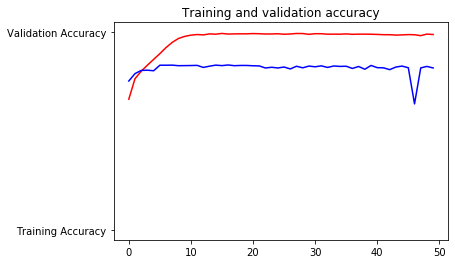

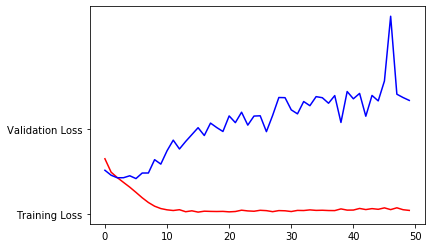

<Figure size 432x288 with 0 Axes>

In [16]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


# Desired output. Charts with training and validation metrics. No crash :)